Импортируем необходимые библиотеки

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist         # библиотека базы выборок Mnist
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input
from keras.models import Model

Загружаем датасет рукописных цифр MNIST

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


Стандартизация входных данных

In [3]:
x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

In [6]:
def create_dense_ae():
    # Размерность кодированного представления
    encoding_dim = 49

    # Энкодер
    # Входной плейсхолдер
    input_img = Input(shape=(28, 28, 1)) # 28, 28, 1 - размерности строк, столбцов, фильтров одной картинки, без батч-размерности
    # Вспомогательный слой решейпинга
    flat_img = Flatten()(input_img)
    # Кодированное полносвязным слоем представление
    encoded = Dense(encoding_dim, activation='relu')(flat_img)
    
    # Декодер
    # Раскодированное другим полносвязным слоем изображение
    input_encoded = Input(shape=(encoding_dim,))
    flat_decoded = Dense(28*28, activation='sigmoid')(input_encoded)
    decoded = Reshape((28, 28, 1))(flat_decoded)

    # Модели, в конструктор первым аргументом передаются входные слои, а вторым выходные слои
    # Другие модели можно так же использовать как и слои
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

In [9]:
encoder, decoder, autoencoder = create_dense_ae()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [10]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 49)                38465     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         39200     
Total params: 77,665
Trainable params: 77,665
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Обучаем автоэнкодер
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 2s 7ms/step - loss: 0.2561 - val_loss: 0.1670
Epoch 2/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1502 - val_loss: 0.1348
Epoch 3/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1271 - val_loss: 0.1181
Epoch 4/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1130 - val_loss: 0.1062
Epoch 5/50
235/235 [==============================] - 2s 6ms/step - loss: 0.1030 - val_loss: 0.0978
Epoch 6/50
235/235 [==============================] - 2s 8ms/step - loss: 0.0957 - val_loss: 0.0917
Epoch 7/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0905 - val_loss: 0.0876
Epoch 8/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0870 - val_loss: 0.0846
Epoch 9/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0846 - val_loss: 0.0827
Epoch 10/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0831 - val_loss: 0.0815

In [12]:
%matplotlib inline
import seaborn as sns

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

In [14]:
n = 20
imgs = x_test[:n]
encoded_imgs = encoder.predict(imgs, batch_size=n)
encoded_imgs[0]

array([ 5.4779906 ,  9.424508  , 10.147998  ,  6.871651  ,  8.019818  ,
        4.1986384 ,  3.8117218 , 12.020516  ,  5.144059  ,  9.393641  ,
        4.44069   , 10.772218  ,  5.881055  ,  4.0304995 ,  2.215274  ,
        4.5933375 ,  7.396714  ,  6.9128375 ,  3.7257833 ,  5.4652452 ,
        6.029265  ,  3.440629  ,  6.6382527 ,  8.671874  ,  8.893194  ,
        9.548243  , 12.05024   ,  3.410963  ,  6.98715   ,  5.965678  ,
        7.3404036 ,  3.5615637 ,  6.0897202 , 12.267943  ,  9.733301  ,
        8.351767  ,  5.960986  ,  4.6672378 ,  9.733847  ,  0.12574029,
        5.120209  ,  4.466484  ,  3.697795  ,  3.829916  ,  5.172345  ,
        5.5979886 ,  2.2929482 ,  4.3858852 ,  3.8914962 ], dtype=float32)

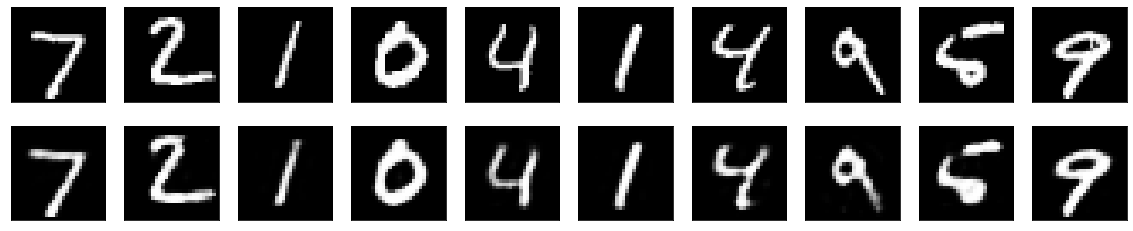

In [15]:
decoded_imgs = decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)